In [5]:
import pandas as pd
df=pd.read_csv("../data/cleaned_data.csv")

In [42]:
df['text_length'] = df['clean_text'].apply(lambda x: len(str(x).split()))
print(f"Lungimea medie a stirilor (numar de cuvinte): {df['text_length'].mean():.2f}")
    

Lungimea medie a stirilor (numar de cuvinte): 234.75


In [43]:
import numpy as np
df['label'].value_counts()



label
0    22763
1    21210
Name: count, dtype: int64

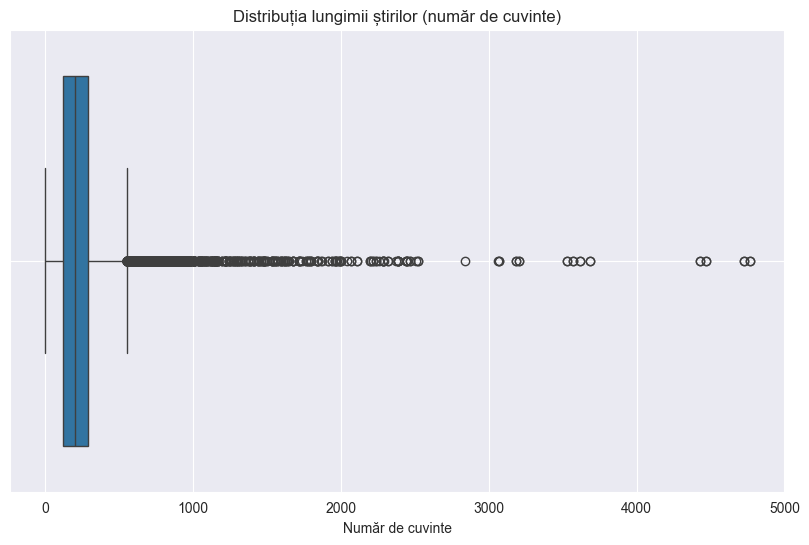

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(x=df['text_length'])
plt.title('Distribuția lungimii știrilor (număr de cuvinte)')
plt.xlabel('Număr de cuvinte')
plt.grid(True)
plt.show()


In [4]:
# import spacy
# 
# nlp = spacy.load("en_core_web_sm")  
# 
# def eliminate_entities(text):
#     doc = nlp(text)
#     
#     
#     entities_to_remove = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG"]]
#     
#     
#     for entity in entities_to_remove:
#         text = text.replace(entity, "")
#     print(text)
#     return text
# df["text_clean_wh_entities"]= df['text'].apply(eliminate_entities)


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


df = df.sample(frac=1)
df = df.dropna(subset=['clean_text', 'label'])


X = df["clean_text"]
y = df["label"]

pipe= make_pipeline(CountVectorizer(),MultinomialNB())
print(pipe)

param_grid = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__min_df': [1, 2, 3, 5],
    'countvectorizer__max_df': [0.85, 0.9, 0.95, 1.0],
    'countvectorizer__stop_words': ['english', None],
    'countvectorizer__max_features': [None, 5000, 10000],
    'multinomialnb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(pipe, param_grid, cv=5,verbose=3)
grid.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END countvectorizer__max_df=0.95, countvectorizer__min_df=2, countvectorizer__ngram_range=(1, 1), multinomialnb__alpha=0.1;, score=0.951 total time=   8.8s
[CV 2/5] END countvectorizer__max_df=0.95, countvectorizer__min_df=2, countvectorizer__ngram_range=(1, 1), multinomialnb__alpha=0.1;, score=0.955 total time=   8.3s
[CV 3/5] END countvectorizer__max_df=0.95, countvectorizer__min_df=2, countvectorizer__ngram_range=(1, 1), multinomialnb__alpha=0.1;, score=0.955 total time=   8.3s
[CV 4/5] END countvectorizer__max_df=0.95, countvectorizer__min_df=2, countvectorizer__ngram_range=(1, 1), multinomialnb__alpha=0.1;, score=0.957 total time=   8.5s
[CV 5/5] END countvectorizer__max_df=0.95, countvectorizer__min_df=2, countvectorizer__ngram_range=(1, 1), multinomialnb__alpha=0.1;, score=0.954 total time=   9.5s
[CV 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'countvectorizer__max_df': [0.95, 0.9],
                         'countvectorizer__min_df': [2, 5],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'multinomialnb__alpha': [0.1, 0.5, 1.0]},
             verbose=3)

In [7]:
print("Best estimator:\n{}".format(grid.best_estimator_))
best_model = grid.best_estimator_


Best estimator:
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB(alpha=0.1))])


In [4]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)
results['param_countvectorizer__ngram_range'] = results['param_countvectorizer__ngram_range'].astype(str)

heatmap_data = results.pivot_table(
    index='param_multinomialnb__alpha',
    columns='param_countvectorizer__ngram_range',
    values='mean_test_score'
)


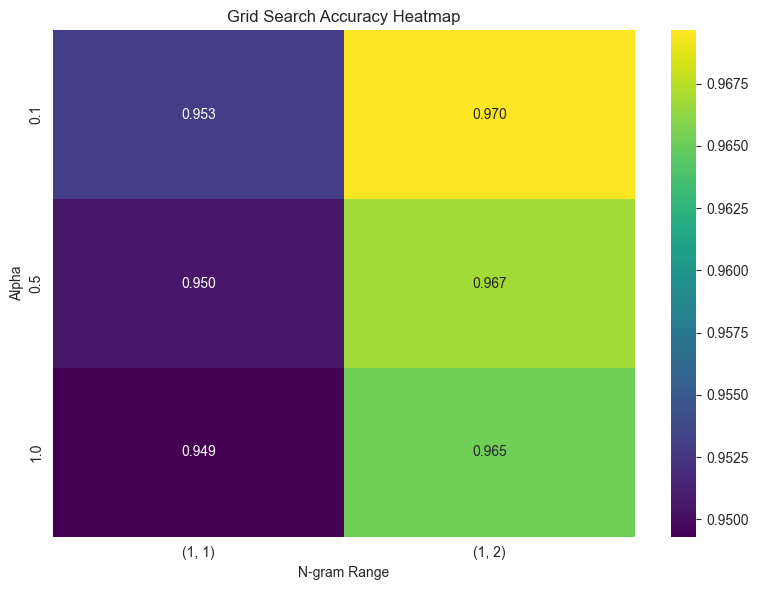

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title("Grid Search Accuracy Heatmap")
plt.ylabel("Alpha")
plt.xlabel("N-gram Range")
plt.tight_layout()
plt.show()


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df = df.sample(frac=1)
df = df.dropna(subset=['clean_text', 'label'])

X = df["clean_text"]
y = df["label"]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)


pipeline = Pipeline([
    ('countvectorizer', CountVectorizer(ngram_range=(3,4), min_df=10, max_df=0.95)),
    ('multinomialnb', MultinomialNB(alpha=1))
])


pipeline.fit(X_train, y_train)


y_pred= pipeline.predict(X_test)
y_pred_train= pipeline.predict(X_train)


In [33]:
from sklearn.metrics import roc_auc_score

# Obține scorurile de probabilitate pentru clasa pozitivă (de obicei clasa 1)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculează ROC AUC
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC AUC Score: {auc_score:.4f}")


ROC AUC Score: 0.9876


In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
report = classification_report(y_test, y_pred)
print("Classification Report (Test):\n", report)

report = classification_report(y_train, y_pred_train)
print("Classification Report (Train):\n", report)

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      6814
           1       0.94      0.97      0.95      6378

    accuracy                           0.95     13192
   macro avg       0.95      0.95      0.95     13192
weighted avg       0.95      0.95      0.95     13192

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     15949
           1       0.95      0.97      0.96     14832

    accuracy                           0.96     30781
   macro avg       0.96      0.96      0.96     30781
weighted avg       0.96      0.96      0.96     30781



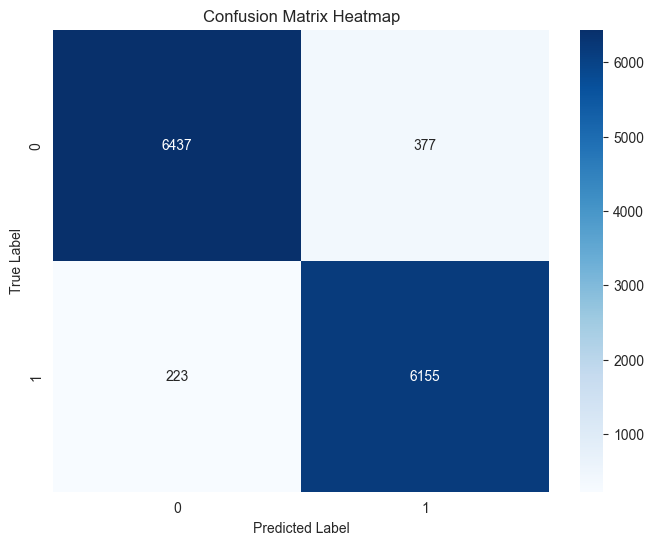

In [36]:
import matplotlib.pyplot as plt 
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


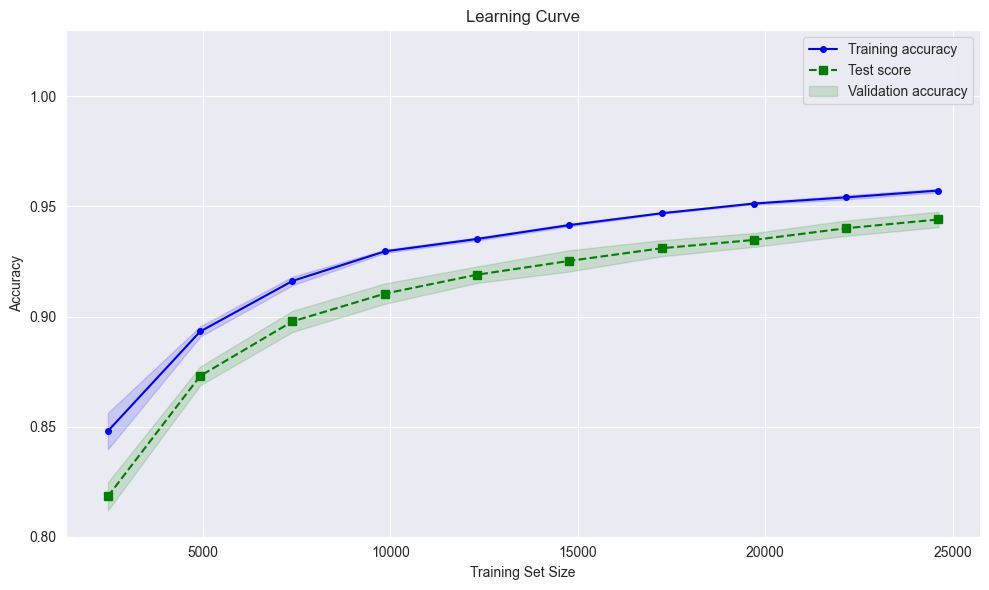

In [28]:
from sklearn.model_selection import learning_curve,train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('countvectorizer', CountVectorizer(ngram_range=(3,4), min_df=10, max_df=0.95)),
    ('multinomialnb', MultinomialNB(alpha=1))
])

X = df["clean_text"].astype(str)
y = df["label"]


X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=0)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,       
    X=X_train,          
    y=y_train,           
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5,              
    scoring='accuracy', 
    n_jobs=10          
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))


plt.plot(train_sizes, train_mean, label="Training accuracy", color='blue', marker='o',markersize='4')
plt.fill_between(train_sizes,
train_mean + train_std,
train_mean - train_std,
alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, label="Test score", color='green',marker='s',linestyle='--')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green',label='Validation accuracy')


plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.ylim([0.8, 1.03])
plt.grid(True)
plt.tight_layout()
plt.show()



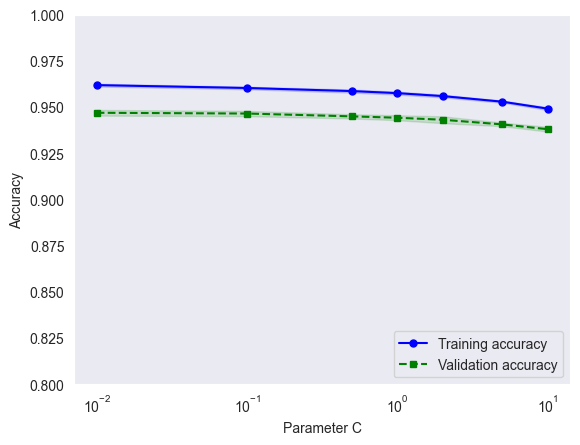

In [23]:
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


pipeline = Pipeline([
    ('countvectorizer', CountVectorizer(ngram_range=(3,4), min_df=10, max_df=0.95)),
    ('multinomialnb', MultinomialNB(alpha=0.5))
])

X = df["clean_text"].astype(str)
y = df["label"]

params =[0.01, 0.1, 0.5, 1.0, 2.0, 5.0,10.0]

train_scores, test_scores = validation_curve(
estimator=pipeline,
X=X_train,
y=y_train,
param_name='multinomialnb__alpha',
param_range=params,
cv=5,
n_jobs=6
)



train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(params, train_mean,
color='blue', marker='o',
markersize=5, label='Training accuracy')
plt.fill_between(params, train_mean + train_std,
train_mean - train_std, alpha=0.15,
color='blue')
plt.plot(params, test_mean,
color='green', linestyle='--',
marker='s', markersize=5,
label='Validation accuracy')

plt.fill_between(params,
test_mean + test_std,
test_mean - test_std,
alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

Accuracy: 0.5237


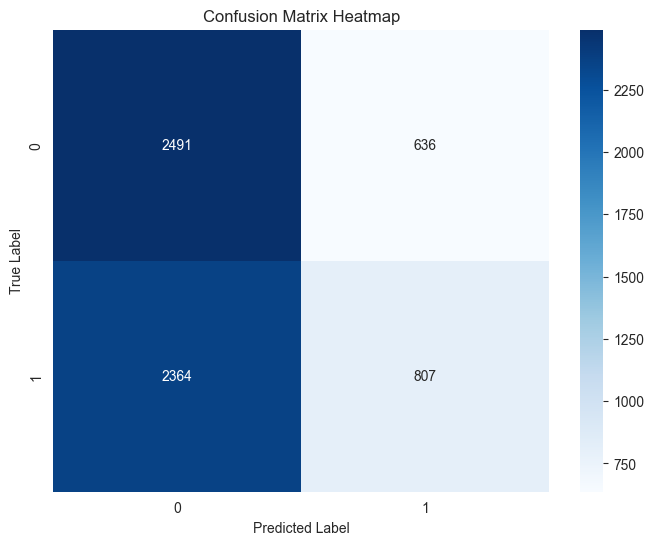

Test performance:
              precision    recall  f1-score   support

           0       0.51      0.80      0.62      3127
           1       0.56      0.25      0.35      3171

    accuracy                           0.52      6298
   macro avg       0.54      0.53      0.49      6298
weighted avg       0.54      0.52      0.49      6298



In [40]:
test_df=pd.read_csv("../data/cleaned_test_data.csv")
test_df=test_df.dropna(subset=['clean_text', 'label'])
X_test=test_df['clean_text']
test_df['label'] = test_df['label'].map({'FAKE': 0, 'REAL': 1})

y_test=test_df['label']
y_pred = pipeline.predict(X_test)

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Test performance:")
print(classification_report(y_test, y_pred))

In [7]:

test_df['predicted_label'] = y_pred
test_df['is_incorrect'] = test_df['predicted_label'] != test_df['label']


incorrect_predictions = test_df[test_df['is_incorrect']]


print(incorrect_predictions[['text', 'label', 'predicted_label']])
incorrect_predictions[['text', 'label']].to_csv('incorrect_predictions.csv', index=False)

print("Fișierul cu predicțiile gresite a fost salvat ca 'incorrect_predictions.csv'")

                                                   text  label  \
4     It's primary day in New York and front-runners...      1   
8     Hillary Clinton and Donald Trump made some ina...      1   
10    CEDAR RAPIDS, Iowa — “I had one of the most wo...      1   
11    Donald Trump’s organizational problems have go...      1   
15    As more women move into high offices, they oft...      1   
...                                                 ...    ...   
6323  ROME —  U.S. Democratic presidential candidate...      1   
6324  Most conservatives who oppose marriage equalit...      1   
6327  The freshman senator from Georgia quoted scrip...      1   
6330  The State Department told the Republican Natio...      1   
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...      1   

      predicted_label  
4                   0  
8                   0  
10                  0  
11                  0  
15                  0  
...               ...  
6323                0  
6324           

In [8]:


# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import CountVectorizer
# from tqdm import tqdm
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import cross_val_score
# import pandas as pd

# X=df["clean_text"]
# y=df["label"]
# 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 
# pipeline = Pipeline([
#     ('vectorizer', CountVectorizer()),
#     ('classifier', MultinomialNB())
# ])
# 
# X_train = X_train.astype(str)
# X_test = X_test.astype(str)
# 
# # Parametri de cautat (grid)
# param_grid = {
#     'vectorizer__ngram_range': [(1,2),(2,3),(1,3)],  
#     'vectorizer__min_df': [1, 2],                              
#     'classifier__alpha': [0.5,0.7, 1.0]          
# }
# 


# cv = StratifiedKFold(n_splits=3)

# 
# grid_search = GridSearchCV(pipeline, param_grid, n_jobs=13,scoring='f1',verbose=4,refit=False)
# 
# 
# grid_search.fit(X_train, y_train)
# 
# # Cele mai bune setari
# print("Best parameters:")
# print(grid_search.best_params_)
# 
# print("\nBest cross-validation score:")
# print(grid_search.best_score_)
# 
# # Evaluare pe test
# best_model = grid_search.best_estimator_
# test_accuracy = best_model.score(X_test, y_test)
# print(f"\nTest set accuracy: {test_accuracy:.4f}")